In [28]:
import jax
import jax.nn as jnn
import jax.numpy as jnp
import numpy as np

import equinox as eqx
import diffrax
import optax

In [29]:
import os
os.chdir("..")
from policy.policy_training import DPCTrainer
from exciting_environments.pmsm.pmsm_env import PMSM
from policy.networks import MLP,MLP2

In [30]:
gpus = jax.devices()
jax.config.update("jax_default_device", gpus[0])

In [31]:
motor_env = PMSM(
    saturated=True,
    LUT_motor_name="BRUSA",
    batch_size=1,
    control_state=[]
)

In [32]:
@eqx.filter_jit
def reset_env(env,rng):
    obs, _ = env.reset(env.env_properties, rng)  #
    obs = obs.at[2].set((3*1500 / 60 * 2 * jnp.pi) / (2 * jnp.pi * 3 * 11000 / 60))
    return obs

In [33]:
@eqx.filter_jit
def motor_env_dat_gen_sin(env,reset_env, rng, traj_len):
    rng, subkey = jax.random.split(rng)
    ref_obs = reset_env(env,subkey) 
    rng, subkey = jax.random.split(rng)
    init_obs = reset_env(env,subkey)  
    return init_obs, ref_obs, rng

In [ ]:
@eqx.filter_jit
def featurize(obs,ref_obs,feat_state=jnp.array([0,0])):
    feat_obs=jnp.concatenate([obs[0:2],obs[6:8],ref_obs[0:2],ref_obs[0:2]-obs[0:2]])
    return feat_obs, feat_state

In [35]:
jax_key = jax.random.PRNGKey(2)
policy=MLP([8,64,64,64,2], key=jax_key)
optimizer = optax.adam(5e-4)
opt_state = optimizer.init(policy)

In [36]:
@eqx.filter_jit
def mse_loss(feat_obs):
    loss=jnp.mean(jnp.sum((feat_obs[:,-2:])**2,axis=1))
    return loss

In [37]:
@eqx.filter_jit
def penalty_loss(feat_obs):
    loss=jnp.array([0])
    return loss

In [ ]:
data_batch_size=50
trainer=DPCTrainer(
    batch_size=data_batch_size,
    train_steps=3000,
    horizon_length=50,
    reset_env=reset_env,
    data_gen_sin=motor_env_dat_gen_sin,
    featurize=featurize,
    policy_optimizer=optimizer,
    ref_loss=mse_loss,
    constr_penalty=penalty_loss,
    ref_loss_weight=1)
keys=jax.vmap(jax.random.PRNGKey)(np.random.randint(0, 2**31, size=(data_batch_size,)))
#key=jax.vmap(jax.random.PRNGKey)(jnp.linspace(0,1000,1001).astype(int))

In [39]:
import matplotlib.pyplot as plt
from utils.evaluation import steps_eval

## Different deadtimes

In [40]:
motor_env_dead1 = PMSM(
    saturated=True,
    LUT_motor_name="BRUSA",
    batch_size=1,
    control_state=[],
    static_params = {
            "p": 3,
            "r_s": 15e-3,
            "l_d": 0.37e-3,
            "l_q": 1.2e-3,
            "psi_p": 65.6e-3,
            "deadtime": 1,
        }
)
motor_env_dead0 = PMSM(
    saturated=True,
    LUT_motor_name="BRUSA",
    batch_size=1,
    control_state=[],
    static_params = {
            "p": 3,
            "r_s": 15e-3,
            "l_d": 0.37e-3,
            "l_q": 1.2e-3,
            "psi_p": 65.6e-3,
            "deadtime": 0,
        }
)

#### dead_train=1 and dead_eval=1

100%|██████████| 3000/3000 [02:54<00:00, 17.14it/s]


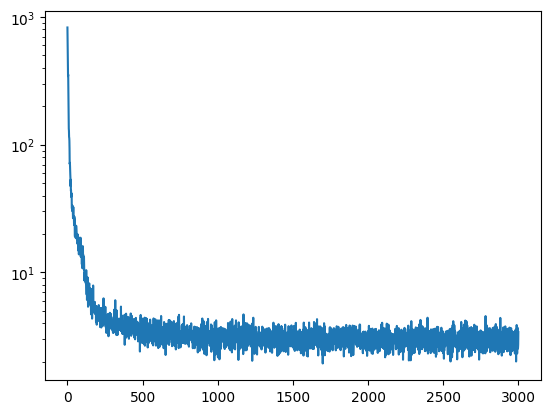

In [41]:
fin_policy_dead1,fin_opt_state3,fin_keys3,losses3=trainer.fit_non_jit(policy,motor_env_dead1,keys,opt_state)
plt.plot(losses3)
plt.yscale('log')

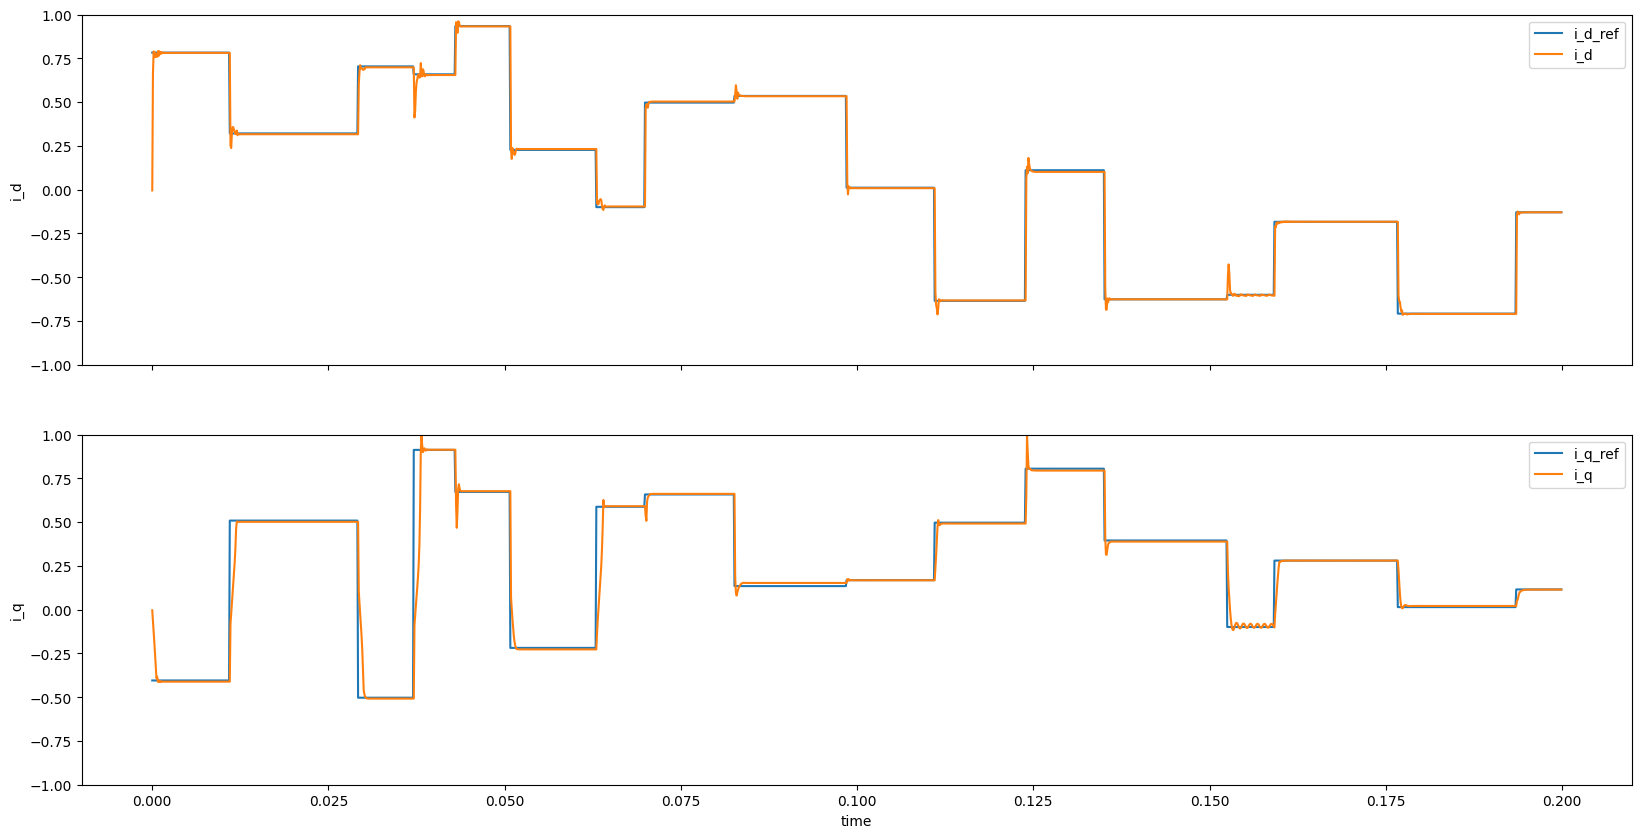

In [ ]:
_,_,_=steps_eval(motor_env_dead1,reset_env,fin_policy_dead1,featurize,jax.random.PRNGKey(2),2000)

#### dead_train=1 and dead_eval=0

In [43]:
# only possible if u_dq_buffer not as feature

#### dead_train=0 and dead_eval=0

100%|██████████| 3000/3000 [02:53<00:00, 17.32it/s]


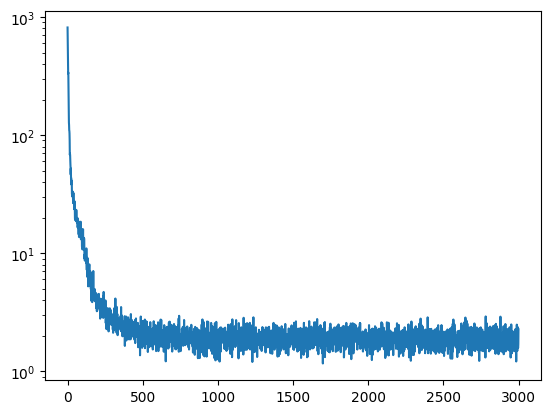

In [44]:
fin_policy_dead0,fin_opt_state3,fin_keys3,losses3=trainer.fit_non_jit(policy,motor_env_dead0,keys,opt_state)
plt.plot(losses3)
plt.yscale('log')

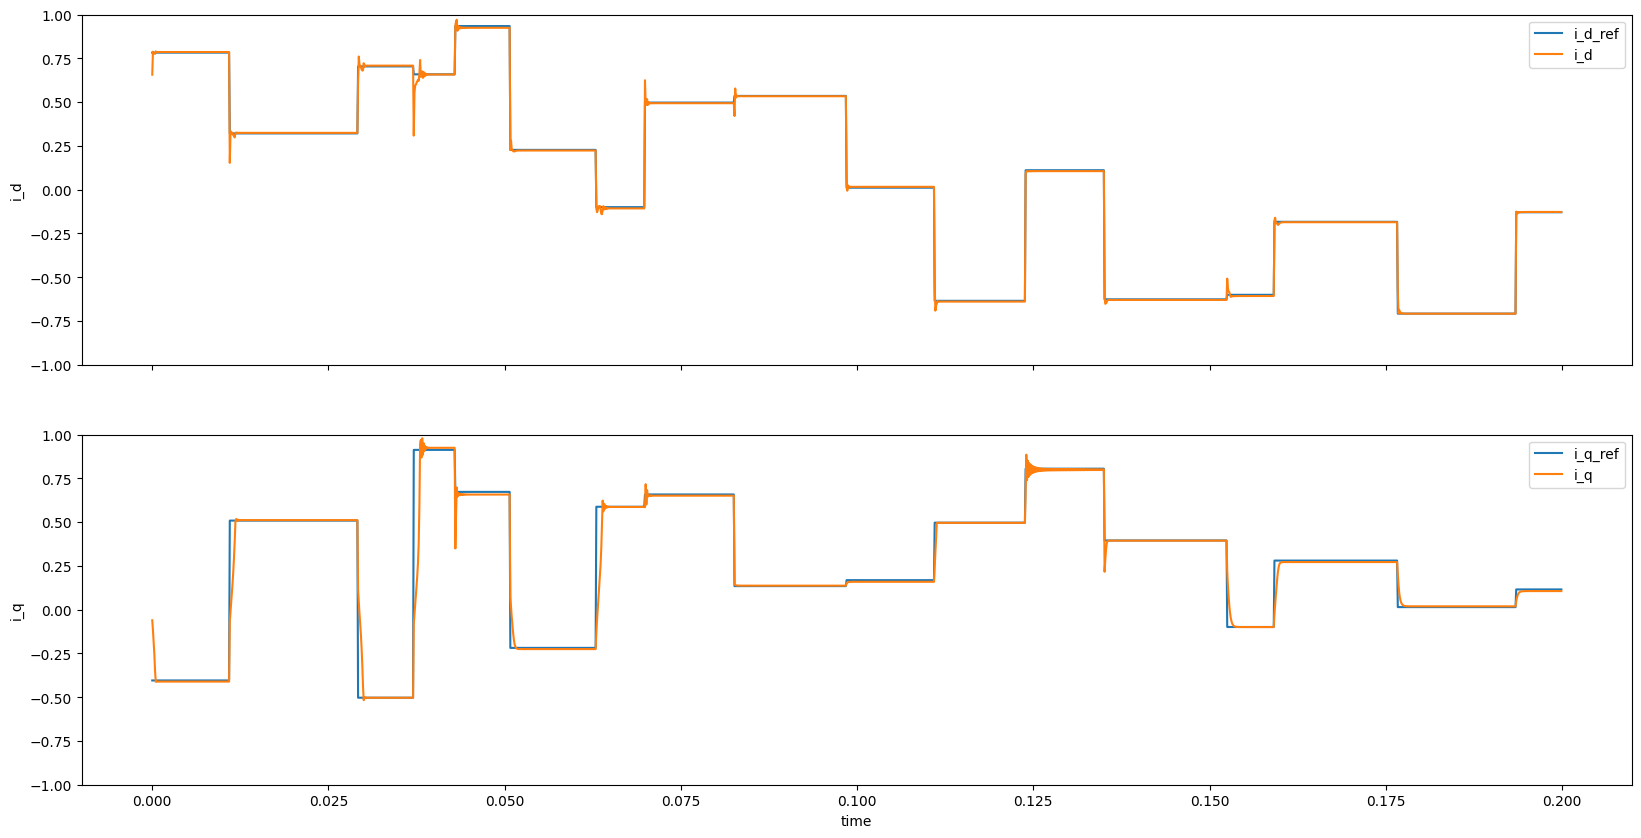

In [ ]:
_,_,_=steps_eval(motor_env_dead0,reset_env,fin_policy_dead0,featurize,jax.random.PRNGKey(2),2000)

#### dead_train=0 and dead_eval=1

In [ ]:
@eqx.filter_jit
def featurize_help(obs,ref_obs,feat_state=jnp.array([0,0])):
    feat_obs=jnp.concatenate([obs[0:2],jnp.array([0.,0.]),ref_obs[0:2],ref_obs[0:2]-obs[0:2]])
    return feat_obs, feat_state

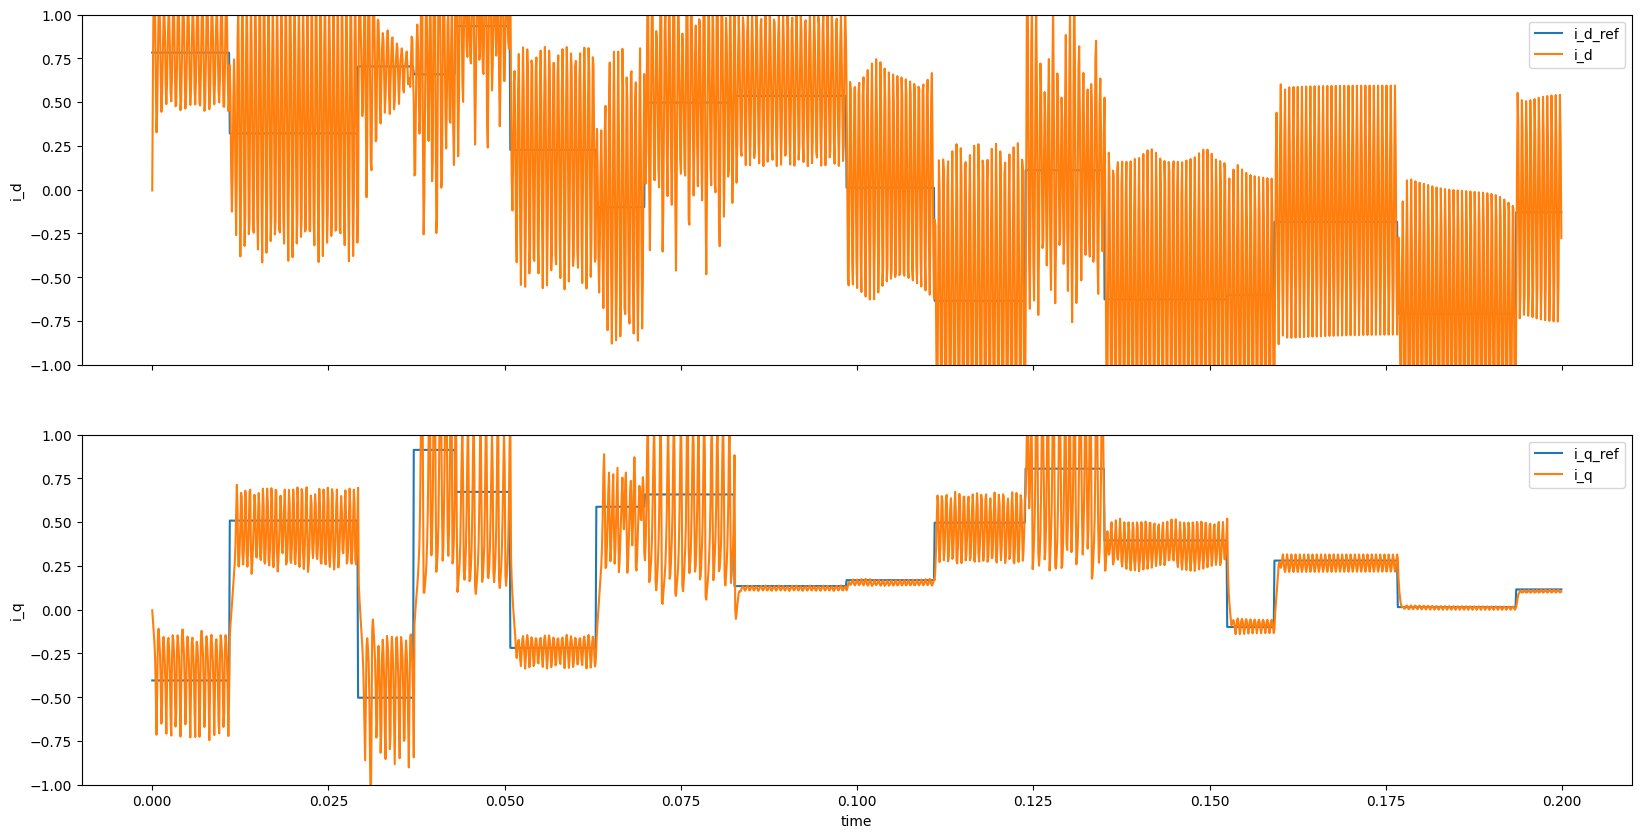

In [47]:
_,_,_=steps_eval(motor_env_dead1,reset_env,fin_policy_dead0,featurize_help,jax.random.PRNGKey(2),2000)

### train dead=1 without buffer

100%|██████████| 3000/3000 [02:56<00:00, 17.00it/s]


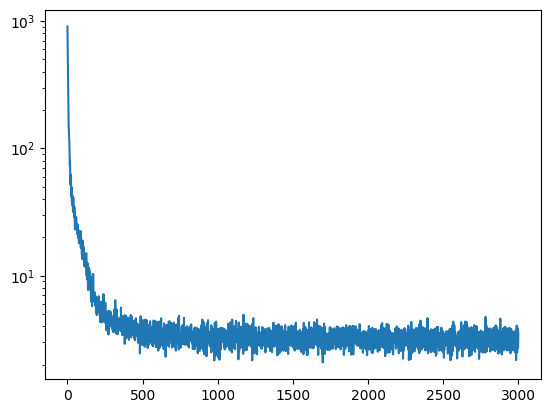

In [ ]:
@eqx.filter_jit
def featurize(obs,ref_obs,feat_state=jnp.array([0,0])):
    feat_obs=jnp.concatenate([obs[0:2],ref_obs[0:2],ref_obs[0:2]-obs[0:2]])
    return feat_obs, feat_state

jax_key = jax.random.PRNGKey(2)
policy=MLP([6,64,64,64,2], key=jax_key)
optimizer = optax.adam(5e-4)
opt_state = optimizer.init(policy)

trainer=DPCTrainer(
    batch_size=data_batch_size,
    train_steps=3000,
    horizon_length=50,
    reset_env=reset_env,
    data_gen_sin=motor_env_dat_gen_sin,
    featurize=featurize,
    policy_optimizer=optimizer,
    ref_loss=mse_loss,
    constr_penalty=penalty_loss,
    ref_loss_weight=1)

fin_policy_dead1_no_buff,fin_opt_state1,fin_keys1,losses2=trainer.fit_non_jit(policy,motor_env,keys,opt_state)
plt.plot(losses2)
plt.yscale('log')

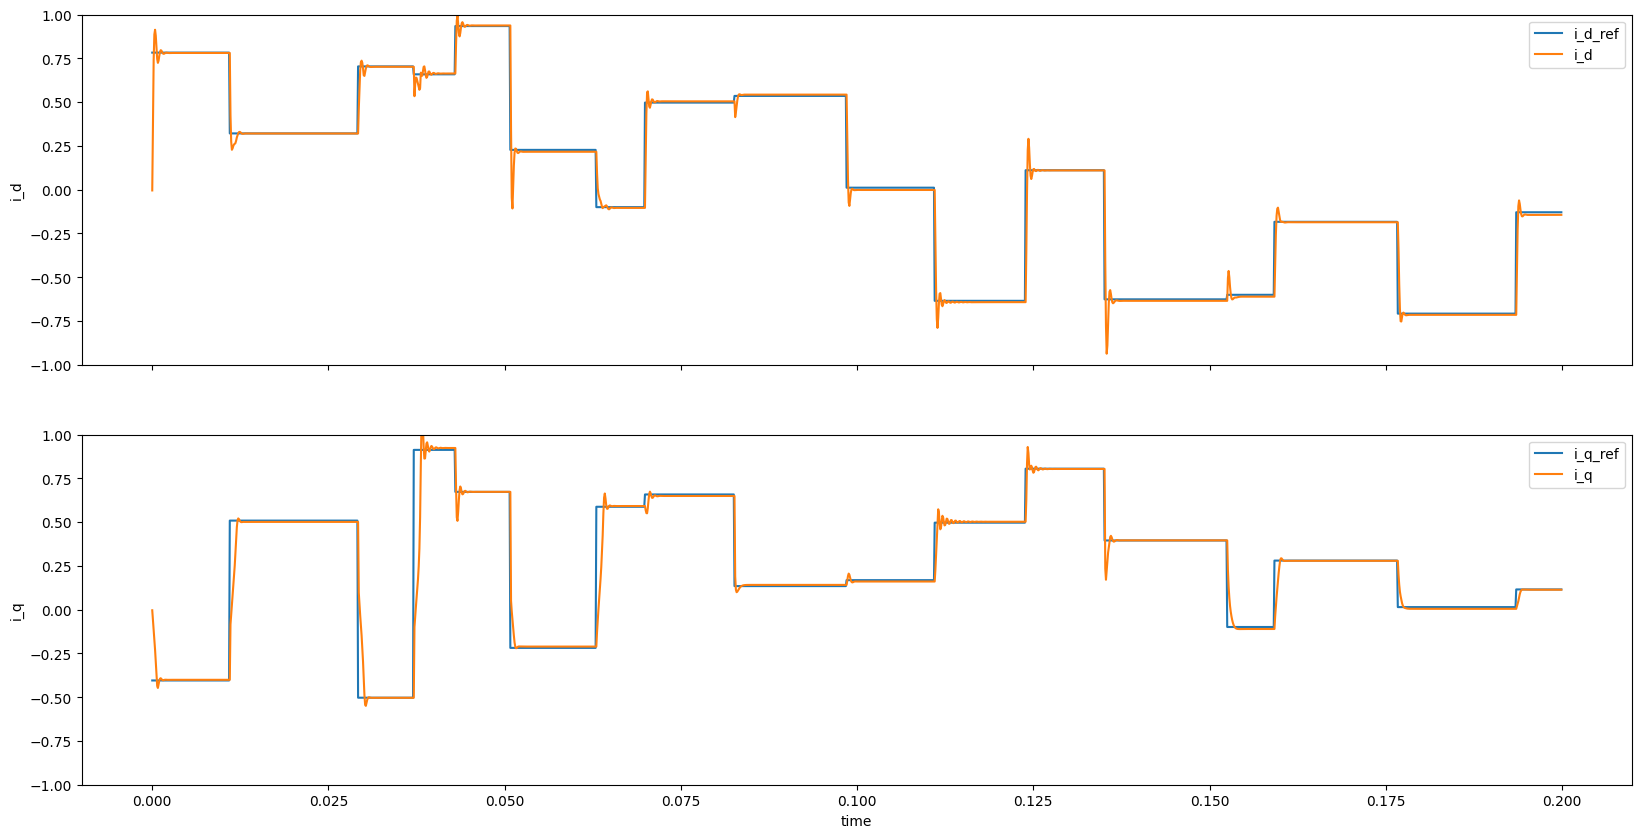

In [50]:
_,_,_=steps_eval(motor_env_dead1,reset_env,fin_policy_dead1_no_buff,featurize,jax.random.PRNGKey(2),2000)

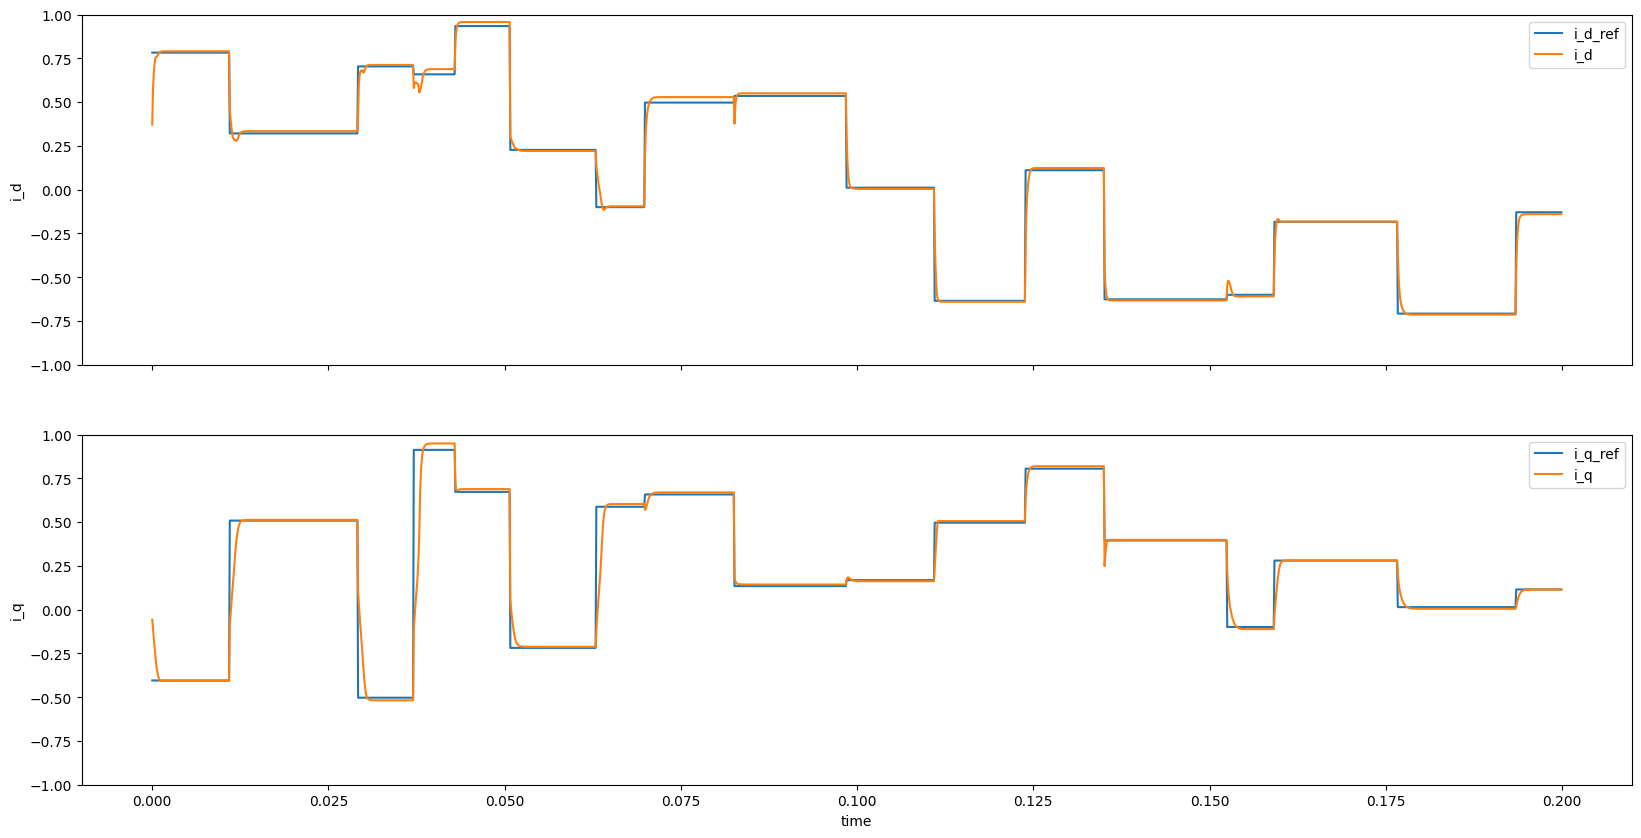

In [51]:
_,_,_=steps_eval(motor_env_dead0,reset_env,fin_policy_dead1_no_buff,featurize,jax.random.PRNGKey(2),2000)

- if buffer is not considered in featurize and it is trained on deadtime=1, than it performs more consistent for different deadtimes